In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd

In [3]:
import datetime as dt
from dateutil.relativedelta import relativedelta

# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func,inspect

In [5]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [6]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [7]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [8]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [9]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Climate Analysis

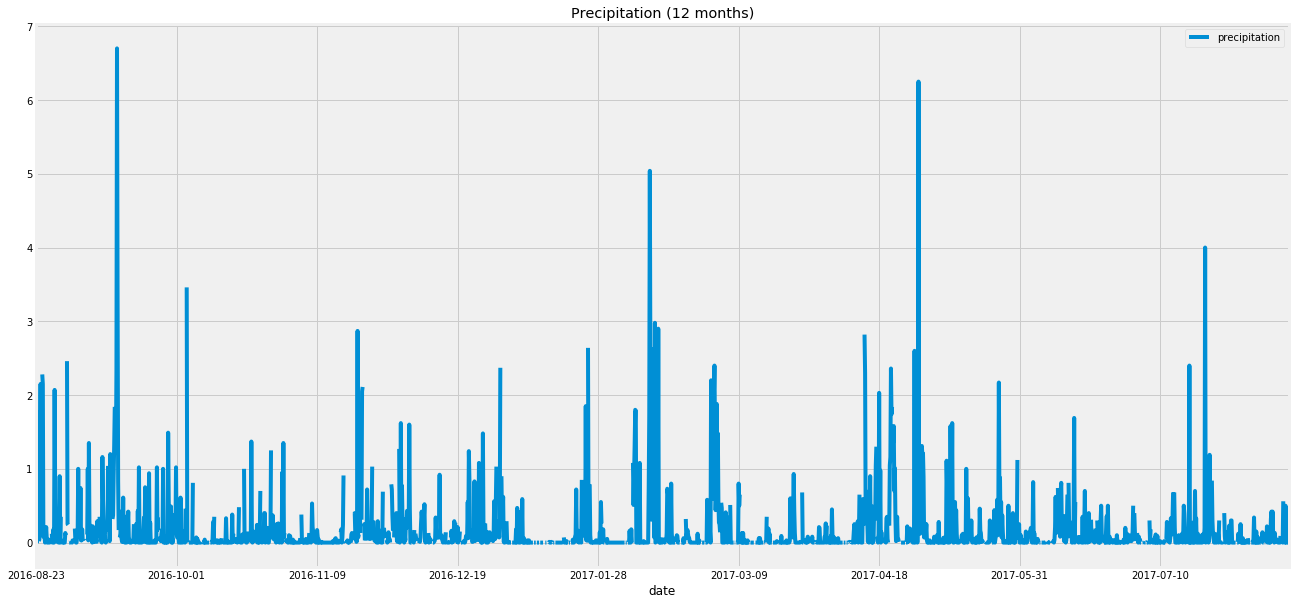

In [10]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results
# Use inspector to understand the table
inspector=inspect(engine)
inspector.get_table_names()
inspector.get_columns("measurement")

# Get the latest date
latest_date=session.query(Measurement.date).order_by(Measurement.date.desc()).first()[0]
latest_date

# Calculate the date 1 year ago from the last data point in the database
one_year_ago=dt.date(2017,8,23)-dt.timedelta(days=366)
one_year_ago

# Perform a query to retrieve the data and precipitation scores
last_12_months=session.query(Measurement.date,Measurement.prcp).order_by(Measurement.date.desc()).\
                filter(Measurement.date>"2016-08-22").all()

# Save the query results as a Pandas DataFrame and set the index to the date column
last_12_month_df=pd.DataFrame(last_12_months,columns=["date","precipitation"])
last_12_month_df

# Sort the dataframe by date
last_12_month_df=last_12_month_df.sort_values(by=["date"],ascending=True)
last_12_month_df=last_12_month_df.set_index('date')
last_12_month_df.head()

# Use Pandas Plotting with Matplotlib to plot the data
last_12_month_df.plot(figsize=(20,10),title="Precipitation (12 months)")


In [11]:
# Use Pandas to calcualte the summary statistics for the precipitation data
last_12_month_df.describe()

,precipitation
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


In [12]:
# Design a query to show how many stations are available in this dataset?
# Use Inspector to understand and examine the table first.
inspector=inspect(engine)
inspector.get_columns("station")

station_count=session.query(Station.station).count()                
print(f"There are {station_count} stations.")

There are 9 stations.


In [13]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
most_active_station=session.query(Measurement.station,func.count(Measurement.station)).group_by(Measurement.station).\
                order_by(func.count(Measurement.station).desc()).all()    
most_active_station

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [14]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature most active station?
# From the result above, the most active station is USC00519281

temperature=session.query(func.max(Measurement.tobs),func.min(Measurement.tobs),func.avg(Measurement.tobs)).\
                          filter(Measurement.station=="USC00519281").all()

print("The most most active station is USC00519281")
print(f"This station's maximum temperature is {temperature[0][0]} degree.")
print(f"This station's minimum temperature is {temperature[0][1]} degree.")
print(f"This station's minimum temperature is {temperature[0][2]} degree.")

The most most active station is USC00519281
This station's maximum temperature is 85.0 degree.
This station's minimum temperature is 54.0 degree.
This station's minimum temperature is 71.66378066378067 degree.


In [15]:
# Choose the station with the highest number of temperature observations.

most_observed_station=session.query(Measurement.station,func.count(Measurement.tobs)).group_by(Measurement.station).\
                order_by(func.count(Measurement.tobs).desc()).first() 

print(f"The station with the highest number of temperature observations is {most_observed_station[0]}.")

# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
past_12_months= session.query(Measurement.date,Measurement.tobs).filter(Measurement.station==most_observed_station[0]).\
                                               filter(Measurement.date>"2016-08-22").all()

#Convert the query object to Pandas dataframe.
past_12_months_df=pd.DataFrame(past_12_months[::],columns=["Dates","Temperature"])
past_12_months_df.head()


The station with the highest number of temperature observations is USC00519281.


,Dates,Temperature
0,2016-08-23,77.0
1,2016-08-24,77.0
2,2016-08-25,80.0
3,2016-08-26,80.0
4,2016-08-27,75.0


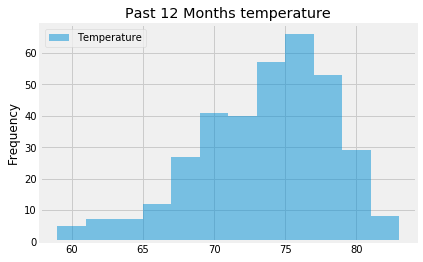

In [16]:
#Plot the resulting pandas dataframe as a histogram

past_12_months_df.plot.hist(bins=12, alpha=0.5)
plt.title('Past 12 Months temperature')
plt.savefig("Image/Temperature_histrogram_past12months")

In [17]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates

def calc_temps(start_date, end_date):
  
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [18]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.

temp_description=calc_temps("2017-08-18","2017-8-23")
temp_description=list(np.ravel(temp_description))
temp_description

[71.0, 79.31818181818181, 85.0]

In [19]:
Min=temp_description[0]
Avg=temp_description[1]
Max=temp_description[2]

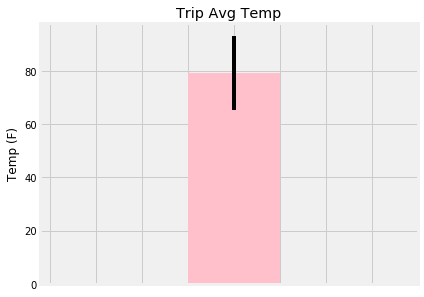

In [20]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)

fig, ax = plt.subplots()
plt.bar(1,Avg, color = 'pink', yerr = Max-Min, align='center',width=0.5)
plt.tick_params(labelbottom=False)         #Remove X-axis label
plt.ylabel("Temp (F)")          #Add y-axis label
plt.xlim(-0.05, 2)
plt.tight_layout()
plt.title('Trip Avg Temp')
plt.savefig("Image/Trip Avg Temp_errorbar")

In [21]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation

rainfall_result=session.query(Measurement.station,func.sum(Measurement.prcp),\
                              Station.name,Station.longitude,Station.latitude,Station.elevation).\
                filter(Station.station==Measurement.station).\
                filter(Measurement.date.between("2017-08-18","2017-8-23")).\
                group_by(Measurement.station).order_by(func.sum(Measurement.prcp).desc()).all()
rainfall_result

[('USC00516128',
  1.5999999999999999,
  'MANOA LYON ARBO 785.2, HI US',
  -157.8025,
  21.3331,
  152.4),
 ('USC00519523',
  0.08,
  'WAIMANALO EXPERIMENTAL FARM, HI US',
  -157.71139,
  21.33556,
  19.5),
 ('USC00519281',
  0.06,
  'WAIHEE 837.5, HI US',
  -157.84888999999998,
  21.45167,
  32.9),
 ('USC00514830',
  0.03,
  'KUALOA RANCH HEADQUARTERS 886.9, HI US',
  -157.8374,
  21.5213,
  7.0),
 ('USC00519397', 0.0, 'WAIKIKI 717.2, HI US', -157.8168, 21.2716, 3.0)]

## Optional Challenge Assignment

In [22]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [26]:
# calculate the daily normals for your trip
day1=daily_normals("08-18")
day2=daily_normals("08-19")
day3=daily_normals("08-20")
day4=daily_normals("08-21")
day5=daily_normals("08-22")
day6=daily_normals("08-23")

# push each tuple of calculations into a list called `normals`
normals=day1,day2,day3,day4,day5,day6

# Set the start and end date of the trip
startdate="2017-08-18"
enddate="2017-8-23"

#Use the start and end date to create a range of dates
date_range = session.query(Measurement.date).filter(Measurement.date.between(startdate,enddate)).group_by(Measurement.date).all()
date_range=list(np.ravel(date_range))
date_range    #try what is date_range[0][5:], this is how you slice a part of a string!

# Stip off the year and save a list of %m-%d strings
without_year= [x[5:] for x in date_range]   
without_year   #This is the list of %m-%d strings

# Loop through the list of %m-%d strings and calculate the normals for each date
result_list=[]
for x in without_year:
    result=session.query(func.min(Measurement.tobs),func.avg(Measurement.tobs),func.max(Measurement.tobs)).\
            filter(func.strftime("%m-%d", Measurement.date) == x).all()
 
    unpacked_result=list(np.ravel(result))
    result_list.append(unpacked_result)

result_list

[[70.0, 76.92307692307692, 84.0],
 [69.0, 75.94642857142857, 85.0],
 [68.0, 76.45283018867924, 82.0],
 [67.0, 76.4, 83.0],
 [69.0, 76.47169811320755, 84.0],
 [67.0, 76.6923076923077, 87.0]]

In [48]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index
result_df=pd.DataFrame(result_list,columns=['tmin', 'tavg', 'tmax'])
result_df["date"]=["08-18","08-19","08-20","08-21","08-22","08-23"]

#Inplace modify the dataframe inplace, instead of creating a new dataframe.
#When inplace=True, you dont need to rename the dataframe.
#when inplace=False, you need to assign to a new variable.
result_df.set_index(["date"],inplace=True) 
result_df.round(2)


,tmin,tavg,tmax
date,,,
08-18,70.0,76.92,84.0
08-19,69.0,75.95,85.0
08-20,68.0,76.45,82.0
08-21,67.0,76.40,83.0
08-22,69.0,76.47,84.0
08-23,67.0,76.69,87.0


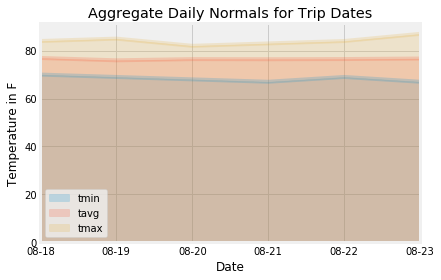

In [49]:
# Plot the daily normals as an area plot with `stacked=False`
ax=result_df.plot(kind='area', alpha=.2, stacked=False, x_compat=True, title="Aggregate Daily Normals for Trip Dates")
plt.tight_layout()
ax.set_xlabel('Date')
ax.set_ylabel('Temperature in F')
plt.savefig("Image/DailyNormals.png")

